In [1]:
import sys
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow import keras 

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
from recommenders.models.vae.multinomial_vae import Mult_VAE

from tempfile import TemporaryDirectory

import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior()

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Instructions for updating:
non-resource variables are not supported in the long term
System version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Pandas version: 1.0.1
Tensorflow version: 2.4.1
Keras version: 2.4.0


In [2]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
# MOVIELENS_DATA_SIZE = '1m'

# Model parameters
HELDOUT_USERS = 3000 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 400
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights
tmp_dir = '../data/train/'
WEIGHTS_PATH = os.path.join(tmp_dir, "mvae_weights.hdf5")

SEED = 42

In [3]:
df = pd.read_csv("/opt/ml/input/data/train/train_ratings.csv")
df["rating"] = 1
df = df[["user", "item", "rating","time"]]
df.columns = ['userID', 'itemID', 'rating',"timestamp"]
df.head()

,userID,itemID,rating,timestamp
0,11,4643,1,1230782529
1,11,170,1,1230782534
2,11,531,1,1230782539
3,11,616,1,1230782542
4,11,2140,1,1230782563


In [4]:
df_preferred = df[df['rating'] > 0]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0]


# df.head()
df_preferred.head(10)

(5154471, 4)


,userID,itemID,rating,timestamp
0,11,4643,1,1230782529
1,11,170,1,1230782534
2,11,531,1,1230782539
3,11,616,1,1230782542
4,11,2140,1,1230782563
5,11,2722,1,1230782583
6,11,2313,1,1230782646
7,11,2688,1,1230782656
8,11,2428,1,1230782694
9,11,3113,1,1230782719


In [5]:
# Keep users who clicked on at least 5 movies
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [6]:
df.shape

(5154471, 4)

In [7]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 5154471 watching events from 31360 users and 6807 movies (sparsity: 2.415%)


In [8]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [9]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS) : (n_users)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[:n_users]
print("\nNumber of test users:", len(test_users))

Number of unique users: 31360

Number of training users: 28360

Number of validation users: 3000

Number of test users: 31360


In [10]:
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

Number of training observations:  4656007

Number of validation observations:  498464

Number of test observations:  5154471


In [11]:
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 6807


In [12]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  498464

Number of test observations after filtering:  5154471


In [13]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [14]:
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(28360, 6807)
(3000, 6807)
(31360, 6807)


In [15]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [16]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0)
val_data = binarize(a=val_data, threshold=0)
test_data = binarize(a=test_data, threshold=0)

In [17]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0)

In [18]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0)

In [19]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value 
  item_old=i['itemID'] # old value 

    
  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value 
      item_new=test_map_items.get(item_old) # new value 
      rating=i['rating'] 
      test_data_te_ratings.at[user_new,item_new]= rating   

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value 
      item_new=val_map_items.get(item_old) # new value 
      rating=i['rating'] 
      val_data_te_ratings.at[user_new,item_new]= rating  


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    
# test_data_te_ratings  

In [20]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

498464.0
373833.0
124631.0
5154471.0
3865715.0
1288756.0


In [21]:
model_with_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                             original_dim=train_data.shape[1], # Number of unique items in the training set
                             intermediate_dim=INTERMEDIATE_DIM, 
                             latent_dim=LATENT_DIM, 
                             n_epochs=EPOCHS, 
                             batch_size=BATCH_SIZE, 
                             k=TOP_K,
                             verbose=0,
                             seed=SEED,
                             save_path=WEIGHTS_PATH,
                             drop_encoder=0.5,
                             drop_decoder=0.5,
                             annealing=True,
                             anneal_cap=1.0,       
                             )


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, 
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '
2022-04-08 02:59:46.832578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-08 02:59:46.832923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 02:59:46.834828: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-08

Took 7641.2748 seconds for training.


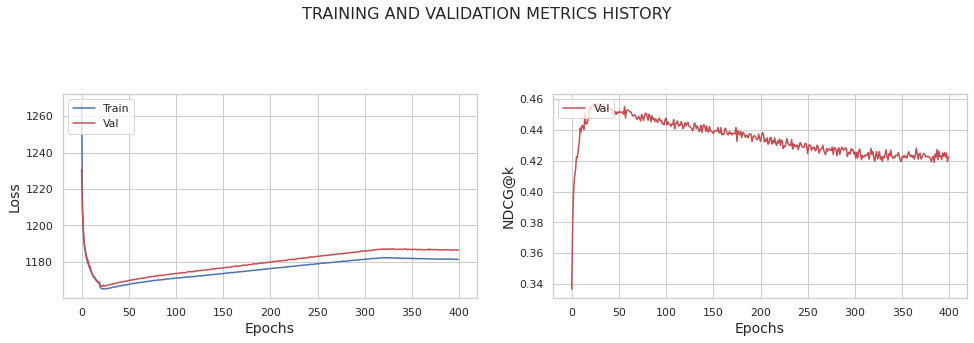

In [23]:
model_with_anneal.display_metrics()

In [24]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

In [25]:
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.10625


In [26]:
model_optimal_beta = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                              original_dim=train_data.shape[1], # Number of unique items in the training set
                              intermediate_dim=INTERMEDIATE_DIM,
                              latent_dim=LATENT_DIM,
                              n_epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              k=TOP_K,
                              verbose=0,
                              seed=SEED,
                              save_path=WEIGHTS_PATH,
                              drop_encoder=0.5,
                              drop_decoder=0.5,
                              annealing=True,
                              anneal_cap=optimal_beta,  
                              )

In [27]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, 
                           mapper=am_val
                           )
    
print("Took {} seconds for training.".format(t))

Took 7397.0495 seconds for training.


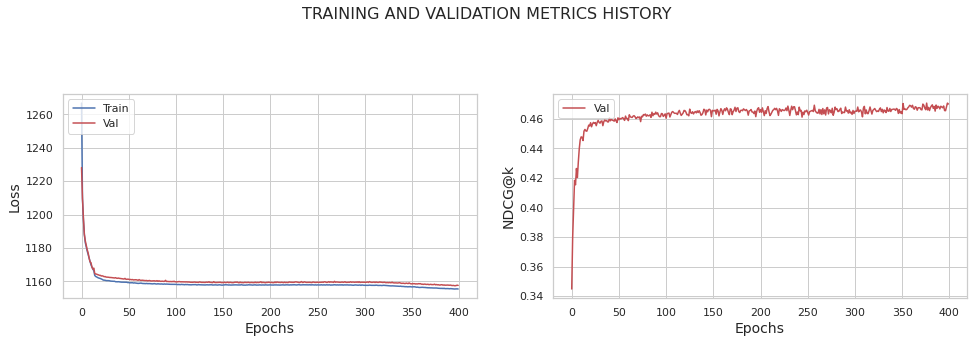

In [28]:
model_optimal_beta.display_metrics()

In [29]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

In [30]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))



Took 18.1165 seconds for prediction.


In [31]:
# # Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

MAP@10:		0.095447
NDCG@10:	0.475214
Precision@10:	0.441856
Recall@10: 	0.138404


In [32]:
top_k_df.shape

(313600, 3)

In [33]:
top_k_df.to_csv("/opt/ml/input/code/output/Multi_VAE.csv", index=False)